### Exploring Non-Gaussianity and Feature Normalization 

In [1]:
from data import Portfolio, Dataset
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Instantiation of Portfolio/Dataset objects

We again start by instantiating our Portfolio object. We are simply interested in a single feature, so we use our favorite technology stock, AAPL.

In [2]:
# define stock list of portfolio (just AAPL in this case)
stock_list = ['AAPL']

# define desired start and end dates
start = '1990-01-01'
end = '2020-01-01'

# construct pandas dataframe of portfolio returns to instantiate Portfolio object 
# (in this case from yfinance)
returns = yf.Ticker('^DJI').history(start=start,end=end)

# construct Portfolio object implemented in data.py
dji = Portfolio('^DJI', stock_list, returns, start=start,end=end)

We next define our features using our stocks and periods, the target, the forward return horizon, target name, and task type (regression or classification)

In [3]:
# define feature names, target name, periods
feature_names = stock_list
target_name = 'returns'
periods = list(range(1,21)) + list(range(40,260,20))
horizon = 5

params = {'pfolio_obj': dji, 
          'data_type': 'Close', 
          'feature_names': stock_list, 
          'periods': periods, 
          'horizon': horizon, 
          'target_name': 'returns', 
          'task_type': 'classification'}

# instantiate data object 
dji_data = Dataset(**params)

For the purposes of our exploration, we only hone in on one feature: WLOG, let us select the 10-day "backward returns" for AAPL.

In [4]:
feature = pd.DataFrame(dji_data.df[('AAPL', 10)], index=dji_data.df.index)

#### Summary Statistics
We first get the statistics of this feature, including kurtosis and skewness:

In [5]:
df_stats = feature.describe()

df_stats.loc['var'] = feature.var()
df_stats.loc['kurtosis'] = feature.kurtosis()
df_stats.loc['skewness'] = feature.skew()
df_stats = df_stats.reindex(['count', 'mean', 'std', 'var', 'kurtosis', 'skewness', 'min', '25%', '50%', '75%', 'max'])
display(df_stats)

,AAPL
,10
count,7313.000000
mean,0.011437
std,0.087224
var,0.007608
kurtosis,6.201566
skewness,-0.021512
min,-0.628032
25%,-0.036705
50%,0.010759


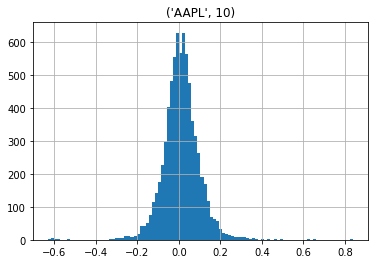

In [6]:
# histogram of returns
hist = feature.hist(bins=100)

The kurtosis of this feature is 6.202, which is greater than the kurtosis of 3 for a univariate Gaussian, making it leptokurtic-it has as a result fatter tails, which is probably expected in backward return distributions.


#### QQ Plotting:
We can now generate a qq plot for this data in order to visually inspect the non-Gaussianity:

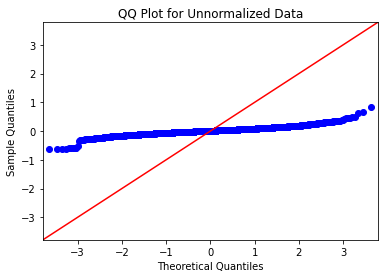

In [7]:
import statsmodels.api as sm

sm.qqplot(feature[('AAPL', 10)].values, line='45')
plt.title('QQ Plot for Unnormalized Data')
plt.show()

The line is approximately horizontal, confirming the presence of heavy tails in our distribution.

We can try exploring the effects of normalization on the qq plot of the dataset; specifically, we use expanding normalization, in which we use an expanding window that takes into account all times $t < t_0$ for a data point at $t_0$.

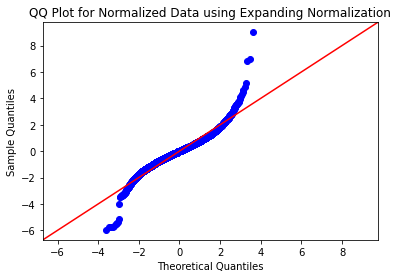

In [8]:
feature['expanding_norm'] = (feature[('AAPL', 10)] - feature[('AAPL', 10)].expanding().mean()) / feature[('AAPL', 10)].expanding().std()
sm.qqplot(feature['expanding_norm'].values[1:], line='45')
plt.title('QQ Plot for Normalized Data using Expanding Normalization')
plt.show()

After normalization, our qq plot appears more similar to the line y=x, with the dispersion at the tail ends still likely due to the heavy tails. By visual inspection, the data is more normal, but we can also quantify this:

#### Kullback-Leibler Divergence

We can also quantify non-Gaussianity by calculating the Kullback-Leibler divergence of the unnormalized and normalized data with respect to a normal distribution, which is an asymmetric measure of the distance between two probability distributions. It is calculated for continuous distributions as:

$$\text{KL}(P \mid\mid Q) = \int_{x \in X} p(x) \log \frac{p(x)}{q(x)} dx$$

Here, $p$ is the empirical PDF of our data, and $q \sim \mathcal{N}(0,1)$.

We can estimate the empirical PDF

In [43]:
from scipy import stats

unnorm_data = np.array(feature[('AAPL', 10)].values).reshape(-1, 1)
norm_data = np.array(feature['expanding_norm'].values[1:]).reshape(-1,1)

(unnorm_pdf, unnorm_edges) = np.histogram(data, bins=100, density=True)
(norm_pdf, norm_edges) = np.histogram(norm_data, bins=100, density=True)

unnorm_q_vals = [stats.norm.cdf(unnorm_edges[i+1]) - norm.cdf(unnorm_edges[i]) for i in range(len(unnorm_edges) - 1)]
norm_q_vals = [stats.norm.cdf(norm_edges[i+1]) - norm.cdf(norm_edges[i]) for i in range(len(norm_edges) - 1)]


print('KL divergence of unnormalized data is', stats.entropy(unnorm_pdf, qk=unnorm_q_vals))
print('KL divergence of normalized data is', stats.entropy(norm_pdf[:-4], qk=norm_q_vals[:-4]))

KL divergence of unnormalized data is 1.3858939962992345
KL divergence of normalized data is 0.07691292725979855


We clearly see that the normalized data has a much smaller KL divergence, indicating that it is closer to being distributed $\mathcal{N}(0,1)$.

#### Jarque-Bera Test



In [46]:
stats.jarque_bera(unnorm_data)
# stats.jarque_bera(norm_data)

(11700.356951514672, 0.0)